# Preparación para Integración de Fuentes Heterogéneas - Monitorización Multimodal de Alzheimer

## Objetivo
#### Preparar todos los datasets procesados para su posterior integración, incluyendo:
- Normalización de identificadores de sujetos
- Estandarización de formatos temporales
- Verificación de consistencia entre fuentes
- Preparación de estructuras de datos compatibles
 
#### Datasets a integrar:
1. **Clinical**: clinical_processed.csv
2. **Demographics**: demographics_latest_final.csv  
3. **Genetics**: genetic_merged_processed.csv
4. **Biomarkers**: integrated_biomarkers.csv
5. **Activity/Sleep**: processed_activity_sleep_subject.csv
6. **Neuroimaging MRI**: mri/mri_features.csv
7. **Neuroimaging PET**: pet/pet_features.csv

***

## Importación de librerías

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

# Para manipulación de datos específicos
import nibabel as nib  # Para datos de neuroimagen
import pydicom  # Para archivos DICOM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer

In [40]:
# Configuraciones
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Definición de Rutas y Carga de Datos Procesados

In [41]:
# Definición de rutas de archivos
BASE_PATH = Path("../data/processed")

# Archivos principales en processed/
files_config = {
    'clinical': BASE_PATH / "clinical_processed.csv",
    'demographics': BASE_PATH / "demographics_latest_final.csv", 
    'genetics': BASE_PATH / "genetic_merged_processed.csv",
    'biomarkers': BASE_PATH / "integrated_biomarkers.csv",
    'activity_sleep': BASE_PATH / "processed_activity_sleep_subject.csv",
    'mri': BASE_PATH / "mri" / "mri_features.csv",
    'pet': BASE_PATH / "pet" / "pet_features.csv"
}

In [42]:
# Verificar existencia de archivos
print("Verificando existencia de archivos:")
for name, path in files_config.items():
    exists = path.exists()
    print(f"  {name}: {'✓' if exists else '✗'} - {path}")

Verificando existencia de archivos:
  clinical: ✓ - ..\data\processed\clinical_processed.csv
  demographics: ✓ - ..\data\processed\demographics_latest_final.csv
  genetics: ✓ - ..\data\processed\genetic_merged_processed.csv
  biomarkers: ✓ - ..\data\processed\integrated_biomarkers.csv
  activity_sleep: ✓ - ..\data\processed\processed_activity_sleep_subject.csv
  mri: ✓ - ..\data\processed\mri\mri_features.csv
  pet: ✓ - ..\data\processed\pet\pet_features.csv


## 1. Carga de Datasets

In [43]:
# Función para cargar datasets con manejo de errores
def load_dataset(filepath, dataset_name):
    """Carga un dataset con manejo de errores y reporte de información básica"""
    try:
        df = pd.read_csv(filepath)
        print(f"\n📊 {dataset_name.upper()} cargado exitosamente:")
        print(f"   - Forma: {df.shape}")
        print(f"   - Columnas: {list(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}")
        return df
    except Exception as e:
        print(f"❌ Error cargando {dataset_name}: {e}")
        return None

# Cargar todos los datasets
datasets = {}
for name, path in files_config.items():
    if path.exists():
        datasets[name] = load_dataset(path, name)
    else:
        print(f"⚠️  Archivo no encontrado: {name}")
        datasets[name] = None


# Resumen general de datasets cargados
print("\n" + "="*60)
print("RESUMEN DE DATASETS CARGADOS")
print("="*60)

loaded_datasets = {k: v for k, v in datasets.items() if v is not None}
print(f"Total de datasets cargados: {len(loaded_datasets)}/{len(files_config)}")

for name, df in loaded_datasets.items():
    print(f"\n{name.upper()}:")
    print(f"  - Filas: {df.shape[0]:,}")
    print(f"  - Columnas: {df.shape[1]}")
    print(f"  - Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


📊 CLINICAL cargado exitosamente:
   - Forma: (14027, 27)
   - Columnas: ['RID', 'VISCODE', 'VISIT_DATE', 'DAYS_SINCE_BASELINE', 'CDMEMORY']...

📊 DEMOGRAPHICS cargado exitosamente:
   - Forma: (4686, 28)
   - Columnas: ['RID', 'PTID', 'VISCODE', 'VISCODE2', 'VISDATE']...

📊 GENETICS cargado exitosamente:
   - Forma: (2769, 49)
   - Columnas: ['PHASE', 'PTID_apoe', 'RID', 'VISCODE', 'GENOTYPE']...

📊 BIOMARKERS cargado exitosamente:
   - Forma: (2450, 13)
   - Columnas: ['RID', 'LCR_GLUCOSE', 'ABETA40', 'ABETA42', 'TAU']...

📊 ACTIVITY_SLEEP cargado exitosamente:
   - Forma: (1777, 46)
   - Columnas: ['subject_id', 'diagnosis', 'age', 'gender', 'steps_mean']...

📊 MRI cargado exitosamente:
   - Forma: (3, 14)
   - Columnas: ['whole_brain_mean', 'whole_brain_std', 'whole_brain_median', 'whole_brain_min', 'whole_brain_max']...

📊 PET cargado exitosamente:
   - Forma: (5, 14)
   - Columnas: ['whole_brain_mean', 'whole_brain_std', 'whole_brain_median', 'whole_brain_min', 'whole_brain_max']

## 2. Análisis de Identificadores de Sujetos

In [45]:
# Análisis de columnas de identificación en cada dataset
def analyze_subject_identifiers(datasets):
    """Analiza las columnas de identificación de sujetos en cada dataset"""
    
    identifier_analysis = {}
    
    for name, df in datasets.items():
        if df is None:
            continue
            
        # Buscar posibles columnas de identificación
        id_columns = []
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['rid', 'id', 'subject', 'patient', 'participant']):
                id_columns.append(col)
        
        # Información sobre identificadores
        identifier_info = {
            'possible_id_columns': id_columns,
            'unique_values_per_column': {},
            'sample_values': {}
        }
        
        for col in id_columns:
            identifier_info['unique_values_per_column'][col] = df[col].nunique()
            identifier_info['sample_values'][col] = df[col].head(5).tolist()
        
        identifier_analysis[name] = identifier_info
    
    return identifier_analysis

id_analysis = analyze_subject_identifiers(loaded_datasets)

# Mostrar análisis de identificadores
print("ANÁLISIS DE IDENTIFICADORES DE SUJETOS")
print("="*50)

for dataset_name, info in id_analysis.items():
    print(f"\n📋 {dataset_name.upper()}:")
    print(f"   Posibles columnas ID: {info['possible_id_columns']}")
    
    for col, unique_count in info['unique_values_per_column'].items():
        sample_vals = info['sample_values'][col]
        print(f"   - {col}: {unique_count} valores únicos")
        print(f"     Ejemplos: {sample_vals}")

ANÁLISIS DE IDENTIFICADORES DE SUJETOS

📋 CLINICAL:
   Posibles columnas ID: ['RID']
   - RID: 4114 valores únicos
     Ejemplos: [2, 2, 2, 2, 2]

📋 DEMOGRAPHICS:
   Posibles columnas ID: ['RID', 'PTID', 'MARITAL_Widowed']
   - RID: 4686 valores únicos
     Ejemplos: [1, 10, 100, 1000, 10001]
   - PTID: 4686 valores únicos
     Ejemplos: ['022_S_0001', '011_S_0010', '068_S_0100', '099_S_1000', '941_S_10001']
   - MARITAL_Widowed: 2 valores únicos
     Ejemplos: [False, False, False, False, False]

📋 GENETICS:
   Posibles columnas ID: ['PTID_apoe', 'RID', 'ID', 'SITEID', 'PTID_tau', 'SAMPLE_ID']
   - PTID_apoe: 2760 valores únicos
     Ejemplos: ['011_S_0002', '011_S_0003', '022_S_0004', '011_S_0005', '100_S_0006']
   - RID: 2760 valores únicos
     Ejemplos: [2, 3, 4, 5, 6]
   - ID: 1159 valores únicos
     Ejemplos: [4.0, 6.0, 8.0, 10.0, 102.0]
   - SITEID: 58 valores únicos
     Ejemplos: [107.0, 107.0, 10.0, 107.0, 4.0]
   - PTID_tau: 121 valores únicos
     Ejemplos: [nan, nan, nan

## 3. Análisis de Columnas Temporales

In [46]:
# Análisis de columnas temporales
def analyze_temporal_columns(datasets):
    """Analiza columnas que pueden contener información temporal"""
    
    temporal_analysis = {}
    
    for name, df in datasets.items():
        if df is None:
            continue
            
        temporal_columns = []
        
        # Buscar columnas temporales por nombre
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in 
                   ['date', 'time', 'year', 'month', 'day', 'visit', 'exam', 'scan']):
                temporal_columns.append(col)
        
        # Buscar columnas que podrían ser fechas por tipo de dato
        for col in df.columns:
            if df[col].dtype == 'object':
                # Verificar si parece una fecha
                sample_vals = df[col].dropna().head(10)
                if len(sample_vals) > 0:
                    # Verificar patrones de fecha comunes
                    sample_str = str(sample_vals.iloc[0])
                    if any(pattern in sample_str for pattern in ['-', '/', '20', '19']):
                        if len(sample_str) >= 8:  # Longitud mínima para fecha
                            if col not in temporal_columns:
                                temporal_columns.append(col)
        
        temporal_info = {
            'temporal_columns': temporal_columns,
            'column_info': {}
        }
        
        for col in temporal_columns:
            col_info = {
                'dtype': str(df[col].dtype),
                'non_null_count': df[col].count(),
                'unique_values': df[col].nunique(),
                'sample_values': df[col].dropna().head(3).tolist()
            }
            temporal_info['column_info'][col] = col_info
        
        temporal_analysis[name] = temporal_info
    
    return temporal_analysis

temporal_analysis = analyze_temporal_columns(loaded_datasets)

# Mostrar análisis temporal
print("ANÁLISIS DE COLUMNAS TEMPORALES")
print("="*50)

for dataset_name, info in temporal_analysis.items():
    print(f"\n📅 {dataset_name.upper()}:")
    if info['temporal_columns']:
        for col in info['temporal_columns']:
            col_info = info['column_info'][col]
            print(f"   - {col}:")
            print(f"     Tipo: {col_info['dtype']}")
            print(f"     Valores no nulos: {col_info['non_null_count']}")
            print(f"     Valores únicos: {col_info['unique_values']}")
            print(f"     Ejemplos: {col_info['sample_values']}")
    else:
        print("   No se encontraron columnas temporales evidentes")

ANÁLISIS DE COLUMNAS TEMPORALES

📅 CLINICAL:
   - VISIT_DATE:
     Tipo: object
     Valores no nulos: 14022
     Valores únicos: 4180
     Ejemplos: ['2017-10-18', '2006-03-06', '2008-08-27']
   - DAYS_SINCE_BASELINE:
     Tipo: float64
     Valores no nulos: 12120
     Valores únicos: 2547
     Ejemplos: [4445.0, 201.0, 1106.0]
   - DAYS_TO_TRANSITION:
     Tipo: float64
     Valores no nulos: 0
     Valores únicos: 0
     Ejemplos: []

📅 DEMOGRAPHICS:
   - VISDATE:
     Tipo: object
     Valores no nulos: 4680
     Valores únicos: 1902
     Ejemplos: ['2005-08-18', '2005-10-26', '2005-12-12']

📅 GENETICS:
   - USERDATE:
     Tipo: object
     Valores no nulos: 1160
     Valores únicos: 127
     Ejemplos: ['2005-08-23', '2005-08-23', '2005-08-23']
   - USERDATE2:
     Tipo: float64
     Valores no nulos: 0
     Valores únicos: 0
     Ejemplos: []
   - update_stamp_apoe:
     Tipo: object
     Valores no nulos: 2769
     Valores únicos: 140
     Ejemplos: ['2005-08-23 00:00:00', '2005

## 4. Análisis de Consistencia Entre Datasets

In [47]:
# Análisis de solapamiento entre sujetos
def analyze_subject_overlap(datasets, id_analysis):
    """Analiza el solapamiento de sujetos entre datasets"""
    
    # Extraer identificadores principales de cada dataset
    subject_sets = {}
    
    for dataset_name, df in datasets.items():
        if df is None:
            continue
            
        id_cols = id_analysis[dataset_name]['possible_id_columns']
        
        if id_cols:
            # Usar la primera columna ID o la que tenga más valores únicos
            main_id_col = id_cols[0]
            if len(id_cols) > 1:
                unique_counts = [(col, df[col].nunique()) for col in id_cols]
                main_id_col = max(unique_counts, key=lambda x: x[1])[0]
            
            subject_sets[dataset_name] = {
                'id_column': main_id_col,
                'subjects': set(df[main_id_col].dropna().astype(str))
            }
        else:
            subject_sets[dataset_name] = {
                'id_column': None,
                'subjects': set()
            }
    
    return subject_sets

subject_sets = analyze_subject_overlap(loaded_datasets, id_analysis)

# Mostrar información de sujetos por dataset
print("ANÁLISIS DE SUJETOS POR DATASET")
print("="*50)

for name, info in subject_sets.items():
    if info['id_column']:
        print(f"\n{name.upper()}:")
        print(f"   Columna ID principal: {info['id_column']}")
        print(f"   Número de sujetos únicos: {len(info['subjects'])}")
        print(f"   Ejemplos de IDs: {list(info['subjects'])[:5]}")
    else:
        print(f"\n{name.upper()}: No se pudo identificar columna de sujetos")

ANÁLISIS DE SUJETOS POR DATASET

CLINICAL:
   Columna ID principal: RID
   Número de sujetos únicos: 4114
   Ejemplos de IDs: ['1011', '4205', '1354', '4028', '461']

DEMOGRAPHICS:
   Columna ID principal: RID
   Número de sujetos únicos: 4686
   Ejemplos de IDs: ['1011', '4205', '1354', '4028', '2052']

GENETICS:
   Columna ID principal: PTID_apoe
   Número de sujetos únicos: 2760
   Ejemplos de IDs: ['082_S_1377', '126_S_4458', '123_S_2055', '022_S_2263', '132_S_1047']

BIOMARKERS:
   Columna ID principal: RID
   Número de sujetos únicos: 2450
   Ejemplos de IDs: ['4205', '1354', '4028', '2052', '6763']

ACTIVITY_SLEEP:
   Columna ID principal: subject_id
   Número de sujetos únicos: 300
   Ejemplos de IDs: ['S_267', 'S_220', 'S_185', 'S_246', 'S_046']

MRI:
   Columna ID principal: patient_id
   Número de sujetos únicos: 3
   Ejemplos de IDs: ['082_S_4224', '082_S_7117', '130_S_5175']

PET:
   Columna ID principal: patient_id
   Número de sujetos únicos: 5
   Ejemplos de IDs: ['002_

In [48]:
print(subject_sets['genetics'].keys())

dict_keys(['id_column', 'subjects'])


In [49]:
# Análisis de intersecciones entre datasets
def calculate_dataset_intersections(subject_sets):
    """Calcula intersecciones entre todos los pares de datasets"""
    
    dataset_names = [name for name, info in subject_sets.items() 
                    if info['id_column'] is not None]
    
    # Inicializar con ceros de tipo entero
    intersection_matrix = pd.DataFrame(
        0,  # Rellenar con 0s inicialmente
        index=dataset_names, 
        columns=dataset_names, 
        dtype=int  # Tipo explícito
    )
    
    for i, dataset1 in enumerate(dataset_names):
        for j, dataset2 in enumerate(dataset_names):
            if i <= j:
                subjects1 = subject_sets[dataset1]['subjects']
                subjects2 = subject_sets[dataset2]['subjects']
                
                if i == j:
                    intersection_count = len(subjects1)
                else:
                    intersection_count = len(subjects1.intersection(subjects2))
                
                # Asignación directa (ya no hay NaN)
                intersection_matrix.loc[dataset1, dataset2] = intersection_count
                intersection_matrix.loc[dataset2, dataset1] = intersection_count
    
    return intersection_matrix


## 5. Preparación para Estandarización

RESUMEN DE CALIDAD DE DATOS

📊 CLINICAL:
   Filas: 14,027
   Columnas: 27
   Memoria total: 4.4 MB
   Top columnas con datos faltantes:
     - DIAGNOSIS_ORDINAL: 100.0%
     - DIAGNOSIS_PREV: 100.0%
     - DIAGNOSIS_TRANSITION: 100.0%
     - DAYS_TO_TRANSITION: 100.0%
     - DXNORM: 78.3%

📊 DEMOGRAPHICS:
   Filas: 4,686
   Columnas: 28
   Memoria total: 3.1 MB
   Top columnas con datos faltantes:
     - RACE_GROUP: 1.1%
     - RACE_GROUP.1: 1.1%
     - MARITAL_STATUS: 0.8%
     - MARITAL_STATUS.1: 0.8%
     - PTEDUCAT: 0.5%

📊 GENETICS:
   Filas: 2,769
   Columnas: 49
   Memoria total: 2.2 MB
   Top columnas con datos faltantes:
     - USERDATE2: 100.0%
     - PTID_tau: 95.3%
     - EXAMDATE: 95.3%
     - VISCODE2: 95.3%
     - RUN: 95.3%

📊 BIOMARKERS:
   Filas: 2,450
   Columnas: 13
   Memoria total: 0.2 MB
   ✓ Sin datos faltantes

📊 ACTIVITY_SLEEP:
   Filas: 1,777
   Columnas: 46
   Memoria total: 0.9 MB
   ✓ Sin datos faltantes

📊 MRI:
   Filas: 3
   Columnas: 14
   Memoria total

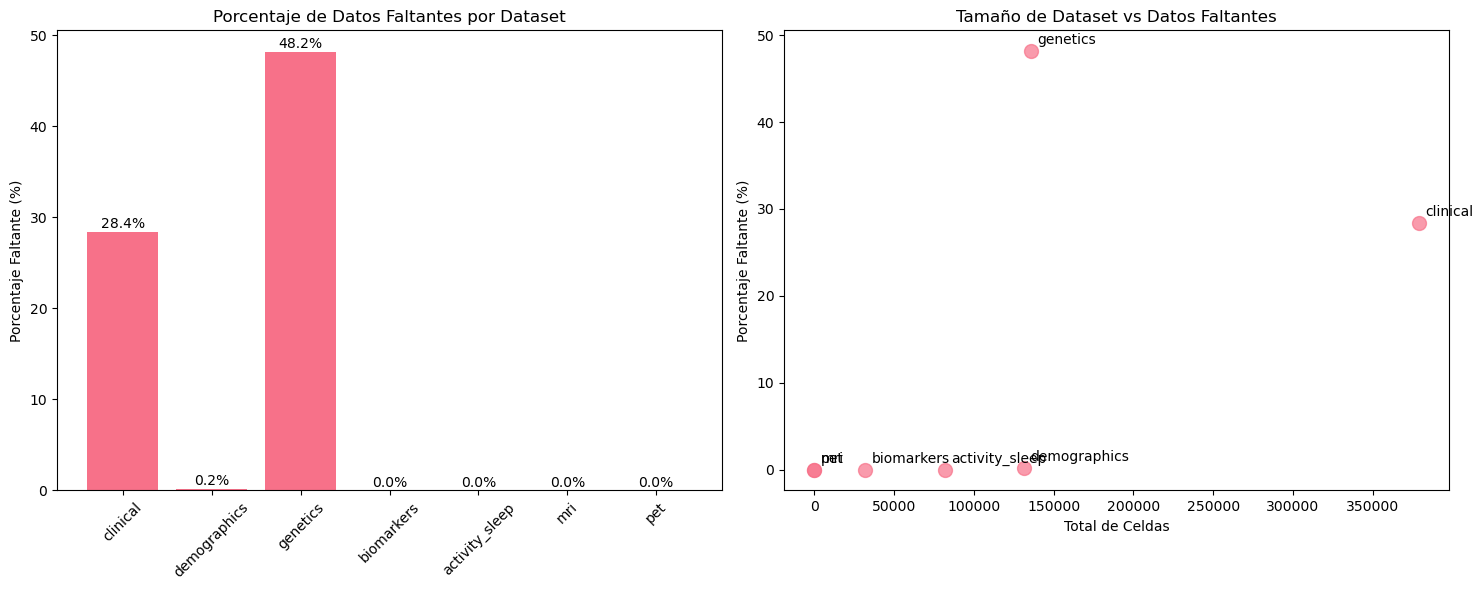


RESUMEN NUMÉRICO DE DATOS FALTANTES:
          Dataset  Missing_Percentage  Total_Cells  Missing_Cells
0        clinical           28.400783       378729         107562
1    demographics            0.202732       131208            266
2        genetics           48.150441       135681          65331
3      biomarkers            0.000000        31850              0
4  activity_sleep            0.000000        81742              0
5             mri            0.000000           42              0
6             pet            0.000000           70              0


In [50]:
# Análisis de tipos de datos y valores faltantes
def analyze_data_quality(datasets):
    """Analiza la calidad de datos en cada dataset"""
    
    quality_report = {}
    
    for name, df in datasets.items():
        if df is None:
            continue
            
        # Análisis por columna
        column_analysis = []
        
        for col in df.columns:
            col_info = {
                'column': col,
                'dtype': str(df[col].dtype),
                'non_null_count': df[col].count(),
                'null_count': df[col].isnull().sum(),
                'null_percentage': (df[col].isnull().sum() / len(df)) * 100,
                'unique_values': df[col].nunique(),
                'memory_usage_mb': df[col].memory_usage(deep=True) / 1024**2
            }
            
            # Análisis específico por tipo de dato
            if df[col].dtype in ['int64', 'float64']:
                col_info.update({
                    'min_value': df[col].min(),
                    'max_value': df[col].max(),
                    'mean_value': df[col].mean(),
                    'std_value': df[col].std()
                })
            elif df[col].dtype == 'object':
                col_info.update({
                    'max_length': df[col].astype(str).str.len().max(),
                    'min_length': df[col].astype(str).str.len().min()
                })
            
            column_analysis.append(col_info)
        
        quality_report[name] = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'total_memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'columns': column_analysis
        }
    
    return quality_report

quality_report = analyze_data_quality(loaded_datasets)

# Resumen de calidad de datos
print("RESUMEN DE CALIDAD DE DATOS")
print("="*50)

for dataset_name, report in quality_report.items():
    print(f"\n📊 {dataset_name.upper()}:")
    print(f"   Filas: {report['total_rows']:,}")
    print(f"   Columnas: {report['total_columns']}")
    print(f"   Memoria total: {report['total_memory_mb']:.1f} MB")
    
    # Top columnas con más valores faltantes
    missing_data = [(col['column'], col['null_percentage']) 
                   for col in report['columns'] if col['null_percentage'] > 0]
    missing_data.sort(key=lambda x: x[1], reverse=True)
    
    if missing_data:
        print(f"   Top columnas con datos faltantes:")
        for col, pct in missing_data[:5]:
            print(f"     - {col}: {pct:.1f}%")
    else:
        print(f"   ✓ Sin datos faltantes")

# %%
# Crear visualización de valores faltantes por dataset
def plot_missing_data_summary(quality_report):
    """Crea visualización resumen de datos faltantes"""
    
    # Preparar datos para visualización
    missing_summary = []
    
    for dataset_name, report in quality_report.items():
        total_cells = report['total_rows'] * report['total_columns']
        total_missing = sum(col['null_count'] for col in report['columns'])
        missing_percentage = (total_missing / total_cells) * 100
        
        missing_summary.append({
            'Dataset': dataset_name,
            'Missing_Percentage': missing_percentage,
            'Total_Cells': total_cells,
            'Missing_Cells': total_missing
        })
    
    missing_df = pd.DataFrame(missing_summary)
    
    # Crear visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico de barras - Porcentaje de datos faltantes
    bars = ax1.bar(missing_df['Dataset'], missing_df['Missing_Percentage'])
    ax1.set_title('Porcentaje de Datos Faltantes por Dataset')
    ax1.set_ylabel('Porcentaje Faltante (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Añadir valores en las barras
    for bar, pct in zip(bars, missing_df['Missing_Percentage']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{pct:.1f}%', ha='center', va='bottom')
    
    # Gráfico de dispersión - Tamaño vs Datos faltantes
    scatter = ax2.scatter(missing_df['Total_Cells'], missing_df['Missing_Percentage'], 
                         s=100, alpha=0.7)
    ax2.set_xlabel('Total de Celdas')
    ax2.set_ylabel('Porcentaje Faltante (%)')
    ax2.set_title('Tamaño de Dataset vs Datos Faltantes')
    
    # Añadir etiquetas
    for i, row in missing_df.iterrows():
        ax2.annotate(row['Dataset'], 
                    (row['Total_Cells'], row['Missing_Percentage']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    return missing_df

missing_summary_df = plot_missing_data_summary(quality_report)
print("\nRESUMEN NUMÉRICO DE DATOS FALTANTES:")
print(missing_summary_df)

## 6. Recomendaciones para Integración

In [51]:
# Generar recomendaciones basadas en el análisis
def generate_integration_recommendations(id_analysis, temporal_analysis, quality_report, subject_sets):
    """Genera recomendaciones para la integración de datos"""
    
    recommendations = {
        'subject_identification': [],
        'temporal_alignment': [],
        'data_quality': [],
        'integration_strategy': []
    }
    
    # Recomendaciones de identificación de sujetos
    datasets_with_ids = [name for name, info in subject_sets.items() 
                        if info['id_column'] is not None]
    
    if len(datasets_with_ids) > 1:
        recommendations['subject_identification'].append(
            f"✓ Se identificaron {len(datasets_with_ids)} datasets con columnas de ID válidas"
        )
        
        # Verificar consistencia en formatos de ID
        id_formats = {}
        for name in datasets_with_ids:
            sample_ids = list(subject_sets[name]['subjects'])[:5]
            id_formats[name] = sample_ids
        
        recommendations['subject_identification'].append(
            "⚠️  Verificar consistencia en formatos de ID entre datasets"
        )
    else:
        recommendations['subject_identification'].append(
            "❌ Pocos datasets con identificadores claros - revisar columnas manualmente"
        )
    
    # Recomendaciones temporales
    datasets_with_temporal = [name for name, info in temporal_analysis.items() 
                             if info['temporal_columns']]
    
    if datasets_with_temporal:
        recommendations['temporal_alignment'].append(
            f"✓ Se encontraron columnas temporales en {len(datasets_with_temporal)} datasets"
        )
        recommendations['temporal_alignment'].append(
            "📋 Estandarizar formatos de fecha antes de la integración"
        )
    else:
        recommendations['temporal_alignment'].append(
            "⚠️  No se detectaron columnas temporales evidentes"
        )
    
    # Recomendaciones de calidad de datos
    high_missing_datasets = []
    for name, report in quality_report.items():
        total_cells = report['total_rows'] * report['total_columns']
        total_missing = sum(col['null_count'] for col in report['columns'])
        missing_pct = (total_missing / total_cells) * 100
        
        if missing_pct > 20:
            high_missing_datasets.append((name, missing_pct))
    
    if high_missing_datasets:
        recommendations['data_quality'].append(
            f"⚠️  Datasets con >20% datos faltantes: {[f'{name} ({pct:.1f}%)' for name, pct in high_missing_datasets]}"
        )
    
    recommendations['data_quality'].append(
        "📋 Implementar estrategias de imputación específicas por modalidad"
    )
    
    # Estrategia de integración
    recommendations['integration_strategy'].append(
        "🔄 Usar merge secuencial comenzando por el dataset con más sujetos"
    )
    recommendations['integration_strategy'].append(
        "📊 Considerar diferentes tipos de join (inner, outer, left) según objetivos"
    )
    recommendations['integration_strategy'].append(
        "🎯 Crear dataset final con estructura jerárquica por modalidad"
    )
    
    return recommendations

recommendations = generate_integration_recommendations(
    id_analysis, temporal_analysis, quality_report, subject_sets
)

# Mostrar recomendaciones
print("RECOMENDACIONES PARA INTEGRACIÓN")
print("="*50)

for category, recs in recommendations.items():
    print(f"\n📋 {category.replace('_', ' ').upper()}:")
    for rec in recs:
        print(f"   {rec}")

RECOMENDACIONES PARA INTEGRACIÓN

📋 SUBJECT IDENTIFICATION:
   ✓ Se identificaron 7 datasets con columnas de ID válidas
   ⚠️  Verificar consistencia en formatos de ID entre datasets

📋 TEMPORAL ALIGNMENT:
   ✓ Se encontraron columnas temporales en 3 datasets
   📋 Estandarizar formatos de fecha antes de la integración

📋 DATA QUALITY:
   ⚠️  Datasets con >20% datos faltantes: ['clinical (28.4%)', 'genetics (48.2%)']
   📋 Implementar estrategias de imputación específicas por modalidad

📋 INTEGRATION STRATEGY:
   🔄 Usar merge secuencial comenzando por el dataset con más sujetos
   📊 Considerar diferentes tipos de join (inner, outer, left) según objetivos
   🎯 Crear dataset final con estructura jerárquica por modalidad


## 7. Prepraración de Metadatos para Integración

In [52]:
# Crear metadatos consolidados para el siguiente notebook
integration_metadata = {
    'datasets_info': {},
    'integration_plan': {
        'primary_key_candidates': {},
        'temporal_columns': {},
        'data_quality_flags': {},
        'recommended_join_order': []
    },
    'preprocessing_needed': {
        'id_standardization': [],
        'temporal_standardization': [],
        'missing_data_strategy': {},
        'dtype_conversions': {}
    }
}

# Llenar metadatos con información analizada
for name, df in loaded_datasets.items():
    if df is None:
        continue
        
    integration_metadata['datasets_info'][name] = {
        'shape': df.shape,
        'primary_id_column': subject_sets[name]['id_column'],
        'subject_count': len(subject_sets[name]['subjects']),
        'temporal_columns': temporal_analysis[name]['temporal_columns'],
        'memory_usage_mb': quality_report[name]['total_memory_mb']
    }
    
    # Candidatos para clave primaria
    if subject_sets[name]['id_column']:
        integration_metadata['integration_plan']['primary_key_candidates'][name] = \
            subject_sets[name]['id_column']
    
    # Columnas temporales
    integration_metadata['integration_plan']['temporal_columns'][name] = \
        temporal_analysis[name]['temporal_columns']

# Orden recomendado de join (por número de sujetos, descendente)
dataset_sizes = [(name, info['subject_count']) 
                for name, info in integration_metadata['datasets_info'].items()
                if info['subject_count'] > 0]
dataset_sizes.sort(key=lambda x: x[1], reverse=True)
integration_metadata['integration_plan']['recommended_join_order'] = \
    [name for name, _ in dataset_sizes]

# Guardar metadatos para el siguiente notebook
print("METADATOS PREPARADOS PARA INTEGRACIÓN")
print("="*50)
print("Información consolidada:")
for key, value in integration_metadata['integration_plan'].items():
    if value:  # Solo mostrar si tiene contenido
        print(f"  {key}: {value}")

# %%
# Resumen final y próximos pasos
print("\n" + "="*60)
print("RESUMEN DE PREPARACIÓN COMPLETADA")
print("="*60)

print(f"\n✅ Datasets analizados: {len(loaded_datasets)}")
print(f"✅ Datasets con identificadores válidos: {len([name for name, info in subject_sets.items() if info['id_column']])}")
print(f"✅ Datasets con información temporal: {len([name for name, info in temporal_analysis.items() if info['temporal_columns']])}")

print(f"\n📋 PRÓXIMOS PASOS (Notebook 08):")
print(f"   1. Estandarización de identificadores de sujetos")
print(f"   2. Normalización de formatos temporales") 
print(f"   3. Integración secuencial de datasets")
print(f"   4. Validación de integridad referencial")
print(f"   5. Creación de dataset multimodal final")

print(f"\n💾 Variables preparadas para exportar:")
print(f"   - loaded_datasets: Datasets cargados")
print(f"   - integration_metadata: Metadatos de integración")
print(f"   - subject_sets: Información de sujetos por dataset")
print(f"   - quality_report: Reporte de calidad de datos")

print(f"\n🚀 Listo para proceder con el notebook 08_data_integration_merge.ipynb")

METADATOS PREPARADOS PARA INTEGRACIÓN
Información consolidada:
  primary_key_candidates: {'clinical': 'RID', 'demographics': 'RID', 'genetics': 'PTID_apoe', 'biomarkers': 'RID', 'activity_sleep': 'subject_id', 'mri': 'patient_id', 'pet': 'patient_id'}
  temporal_columns: {'clinical': ['VISIT_DATE', 'DAYS_SINCE_BASELINE', 'DAYS_TO_TRANSITION'], 'demographics': ['VISDATE'], 'genetics': ['USERDATE', 'USERDATE2', 'update_stamp_apoe', 'APTESTDT_year', 'APTESTDT_month', 'APTESTDT_day', 'USERDATE_year', 'USERDATE_month', 'USERDATE_day', 'update_stamp_year', 'update_stamp_month', 'update_stamp_day', 'EXAMDATE', 'update_stamp_tau', 'EXAMDATE_year', 'EXAMDATE_month', 'EXAMDATE_day', 'APTESTDT', 'SAMPLE_ID'], 'biomarkers': [], 'activity_sleep': [], 'mri': [], 'pet': []}
  recommended_join_order: ['demographics', 'clinical', 'genetics', 'biomarkers', 'activity_sleep', 'pet', 'mri']

RESUMEN DE PREPARACIÓN COMPLETADA

✅ Datasets analizados: 7
✅ Datasets con identificadores válidos: 7
✅ Datasets con

En este punto es sumamente importante aclarar que la variable elegida para ser ___primary_key___ en el dataset 'genetics' es ´´RID´´ y no ´´PTID_apoe´´

## 

***

__Abraham Tartalos__